<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 2 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<span style="color:black; font-size: 14pt">Plan</span>

* <span style="color:black"> Работа с признаками (30 минут) </span>
    * <span style="color:black"> Числовые и категориальные признаки </span>
    * <span style="color:black"> Обработка пропусков </span>
    * <span style="color:black"> Отбор признаков </span>


* <span style="color:black"> Метрики (30 минут)</span>
    * <span style="color:black"> Метрики для Классификации </span>
    * <span style="color:black"> Метрики для регрессии</span>
    * <span style="color:black"> Метрики точности и взгляд на них со стороны баейсовского подхода </span>


* <span style="color:black"> Cross validation and bias-variance trade off (20 минут) </span>
    - <span style="color:black"> cross-validation </span>
    - <span style="color:black"> bias-variance paradigm </span>
    - <span style="color:black"> HW#1 </span>

<span style="color:black; font-size: 14pt">Key words</span>
   * кросс-валидация: назначение (переобучение) и различные варианты кросс-валидации
   * <span style="color:black"> bias-variance tradeoff (смещение и разброс) </span>
   * <span style="color:black"> recall, precise, F2, MSE, MAE, Log-loss, MAPE  </span>
   * <span style="color:black"> нормировка признаков, обработка пропусков</span>
   * <span style="color:black"> отбор признаков, ADD-DELL, обработка пропусков</span>

### Imports

In [13]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib

from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
# from sklearn.neighbors.base import _get_weights
%matplotlib inline

-------
<h1 align="center"> Работа с признаками </h1> 
# Числовые и категориальные признаки

** Вопросы **
* Какую использовать метрику точности предсказаний при несбалансированных классах?

In [3]:
# Используются данные из https://archive.ics.uci.edu/ml/datasets/Adult
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split()

In [4]:
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


** Соотношение классов **

In [6]:
df.groupby('salary').count()[['age']]

,age
salary,
<=50K,24720
>50K,7841


### Нарисуем гистограммы

In [14]:
def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(df)
encoded_data.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


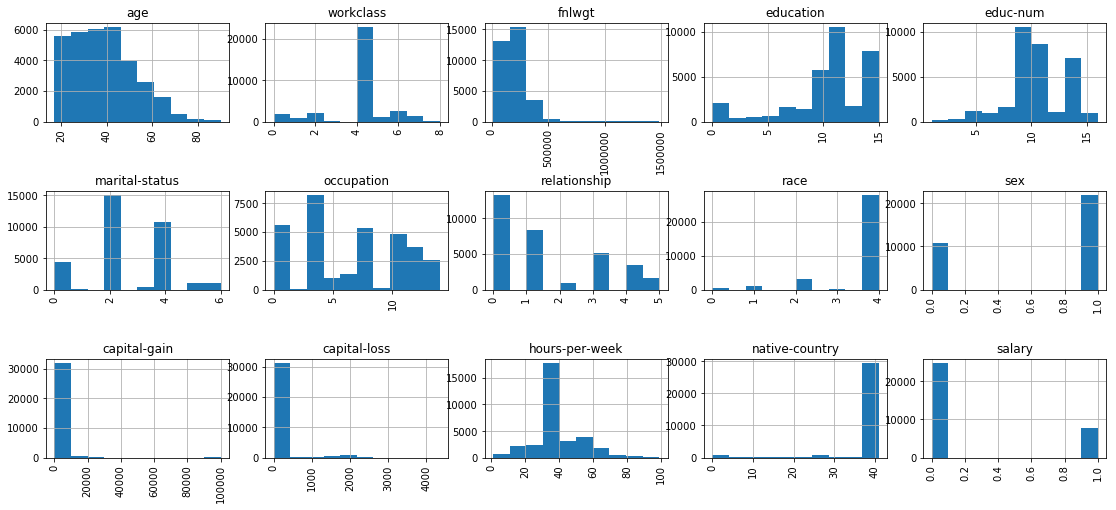

In [15]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Построим матрицу корреляций

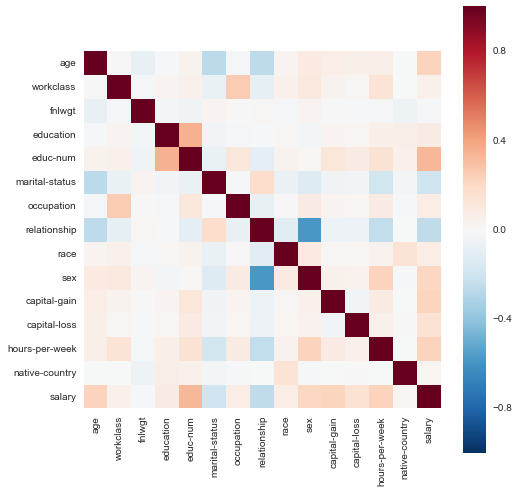

In [65]:
plt.subplots(figsize=(8,8))
encoded_data, encoders = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

### Поделим выборку на train/test

In [67]:
X, y = binary_data[binary_data.columns[:-2]].values, binary_data['salary_ >50K'].values

X_train, y_tain = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

### Тренируем 2 классификаторва 
- умный LinearSVC
- глупый -- DummyClassifier (самый популярный класс)

In [68]:
clf_nn = svm.LinearSVC().fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [69]:
y_nn = clf_nn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [70]:
y_nn

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [71]:
y_mp

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [72]:
y_test

array([ 0.,  0.,  1., ...,  0.,  0.,  1.])

<h1 align="center"> Метрики </h1> 
# Метрики для задачи классификации
### Accuracy

### $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

In [74]:
print 'svm =', metrics.accuracy_score(y_test, y_nn), 'mp =', metrics.accuracy_score(y_test, y_mp)

svm = 0.763840255308 mp = 0.757900802269


### Conf-matrix

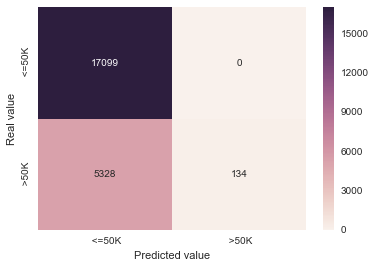

In [75]:
nn_mtx = metrics.confusion_matrix(y_test, y_nn)

sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

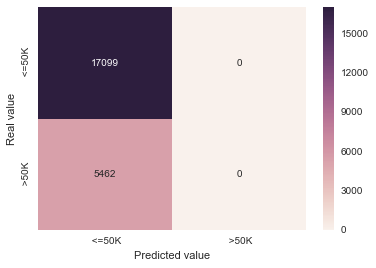

In [76]:
mp_mtx = metrics.confusion_matrix(y_test, y_mp)

sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

### Precision

### $$Precision = \frac{TP}{TP + FP}$$

In [77]:
print 'svm =', metrics.precision_score(y_test, y_nn), 'mp =', metrics.accuracy_score(y_test, y_mp)

svm = 1.0 mp = 0.757900802269


Приведите пример работы классификатора когда precition большой а классификатор работает плохо?

### Recall

### $$Recall = \frac{TP}{TP + FN}$$

In [78]:
print 'svm =', metrics.recall_score(y_test, y_nn), 'mp =', metrics.recall_score(y_test, y_mp)

svm = 0.0245331380447 mp = 0.0


Приведите пример работы классификатора когда recall большой а классификатор работает плохо?

### F1

Что важнее, точность или полнота? Какое среднее выбрать?

### $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

- Среднее арифметичиское плохо -- (p=0.5, r=0.5) сильно лучше чем (p=1, r=0), 
- Лучше минимум, но при равной точности должен побеждать классфикатор с большей полнотой
- Гармоничиское среднее, сглаженный минимум

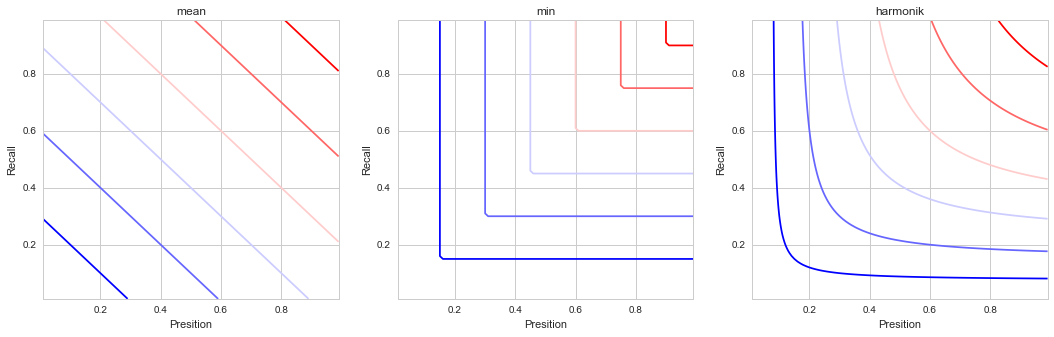

In [80]:

fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

x_, y_ = np.arange(0.01, 1, 0.01), np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x_, y_)

Z = [[0.5*x + 0.5*y  for x in x_] for y in y_]
axs[0].contour(X, Y, Z)
axs[0].set_title('mean')
axs[0].set_xlabel('Presition')
axs[0].set_ylabel('Recall')

Z = [[min(x, y)  for x in x_] for y in y_]
axs[1].contour(X, Y, Z)
axs[1].set_title('min')
axs[1].set_xlabel('Presition')
axs[1].set_ylabel('Recall')


Z = [[scipy.stats.hmean([x, y])  for x in x_] for y in y_]
axs[2].contour(X, Y, Z)
axs[2].set_title('harmonik')
axs[2].set_xlabel('Presition')
axs[2].set_ylabel('Recall')

pylab.show()

In [81]:
print 'knn =', metrics.f1_score(y_test, y_nn), 'mp =', metrics.f1_score(y_test, y_mp)

knn = 0.047891350965 mp = 0.0


### Multiclass Precision-Recall

#### Загрузим датасет с тремя классами

In [82]:
df_iris = sns.load_dataset("iris")
df_iris = df_iris.sample(n=150)

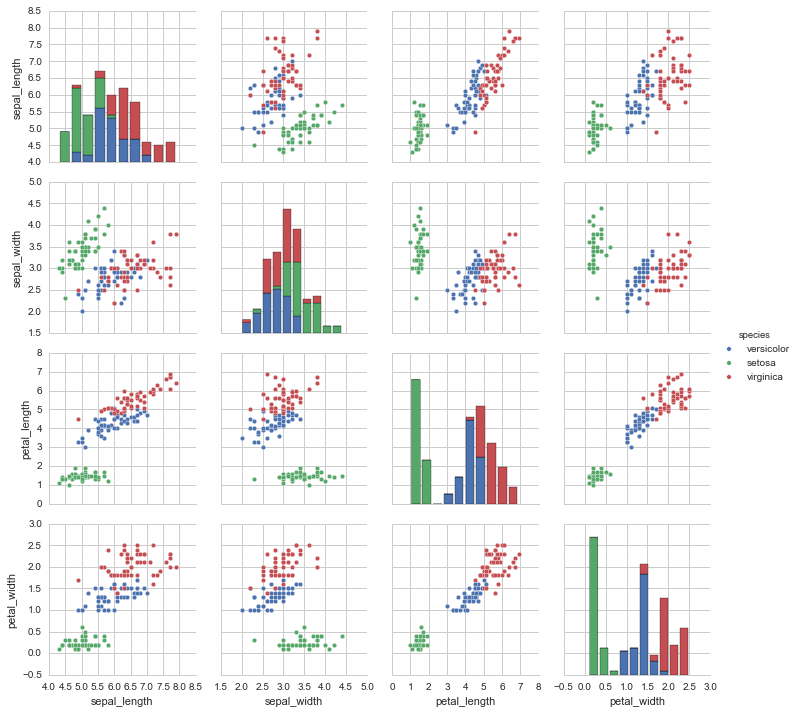

In [83]:
sns.pairplot(df_iris, hue="species")

In [84]:
df_iris, encoders = number_encode_features(df_iris)
iris_X, iris_y = df_iris[df_iris.columns[:-1]].values, df_iris[df_iris.columns[-1]].values

iris_X_train, iris_y_tain = iris_X[:30], iris_y[:30]
iris_X_test, iris_y_test = iris_X[40:], iris_y[40:]

In [86]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
54,6.5,2.8,4.6,1.5,1
49,5.0,3.3,1.4,0.2,0
122,7.7,2.8,6.7,2.0,2
6,4.6,3.4,1.4,0.3,0
148,6.2,3.4,5.4,2.3,2


In [87]:
iris_clf_nn = svm.LinearSVC().fit(iris_X_train, iris_y_tain)
iris_clf_mp = dummy.DummyClassifier("most_frequent").fit(iris_X_train, iris_y_tain)

In [88]:
iris_y_nn = iris_clf_nn.predict(iris_X_test)
iris_y_mp = iris_clf_mp.predict(iris_X_test)

Пусть выборка состоит из K классов. Рассмотрим K двухклассовых задач, каждая из которых заключается в отделении своего класса от остальных, то есть целевые значения для k-й задаче вычисляются как $y_{ik} = [yi = k]$. Для каждой из них можно вычислить различные характеристики (TP, FP, и т.д.) алгоритма $a_k(x) = [a(x) = k]$.

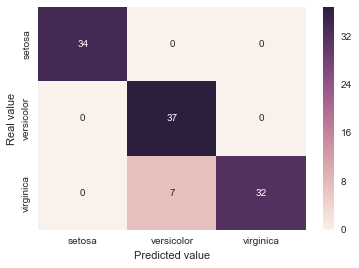

In [90]:
mp_mtx = metrics.confusion_matrix(iris_y_test, iris_y_nn)

sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["species"].classes_, 
            yticklabels=encoders["species"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

**Macro-averaging** -- подсчет TP, FN, TN, FP для каждого класса, а после подсчет точности и полноты.

**Micro-averaging** -- подсчет  точности и полноты для каждого класса, а после подсчет их среденего.

In [91]:
print 'macro', metrics.f1_score(iris_y_test, iris_y_nn, average='macro')
print 'micro', metrics.f1_score(iris_y_test, iris_y_nn, average='micro')
iris_y_nn[iris_y_nn==1] = 0
print 'macro', metrics.f1_score(iris_y_test, iris_y_nn, average='macro')
print 'micro', metrics.f1_score(iris_y_test, iris_y_nn, average='micro')

macro 0.938329565873
micro 0.936363636364
macro 0.502850435949
micro 0.6


### AUC-ROC

In [92]:
clf_nn = neighbors.KNeighborsRegressor().fit(X_train, y_tain)
clf_mp = neighbors.KNeighborsRegressor(n_neighbors=2).fit(X_train, y_tain)

In [93]:
y_nn = clf_nn.predict(X_test)
y_mp = clf_mp.predict(X_test)

ROC AUC = 0.6337


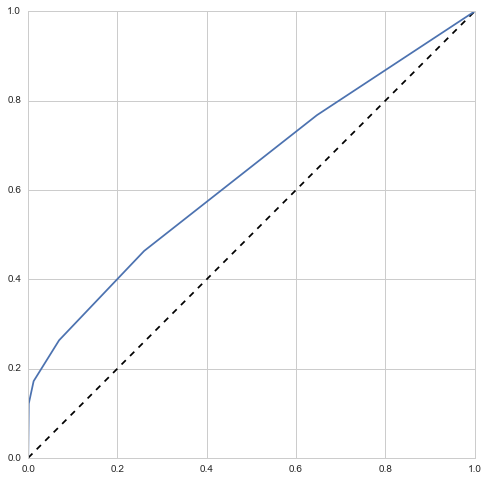

In [94]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_nn)
pylab.figure(figsize=(8, 8))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print 'ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr))

ROC AUC = 0.6304


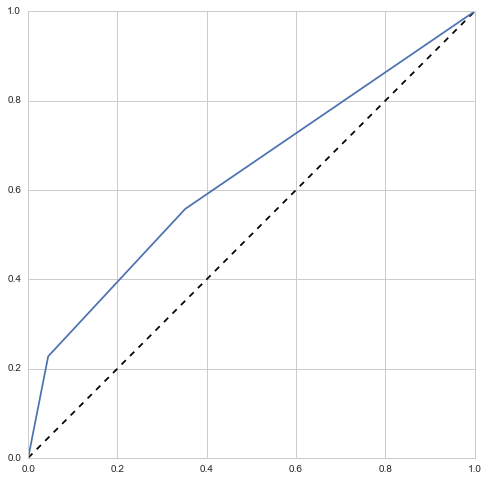

In [95]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_mp)
pylab.figure(figsize=(8, 8))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print 'ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr))

### PR AUC

Когда AUC большой при плохой работе классивфикатора?

PR AUC = 0.2333


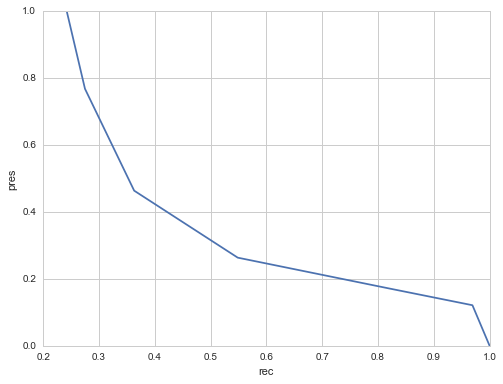

In [101]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_nn)
pylab.figure(figsize=(8, 6))
pylab.plot(pres, rec)
pylab.ylabel('pres')
pylab.xlabel('rec')
print 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec))

In [105]:
pres, rec

(array([ 0.2420992 ,  0.33612982,  0.61864407,  1.        ]),
 array([ 1.        ,  0.5574881 ,  0.22720615,  0.        ]))

PR AUC = 0.2274


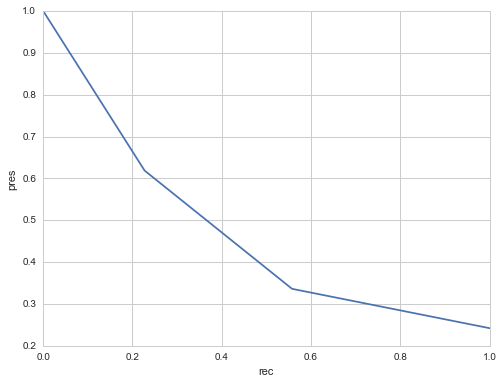

In [104]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_mp)
pylab.figure(figsize=(8, 6))
pylab.plot(rec, pres)
pylab.ylabel('pres')
pylab.xlabel('rec')
print 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec))

Когда PR кривая не адекватна?

<h1 align="center"> Bias-Variance TradeOff </h1> 
# Кросс-валидация

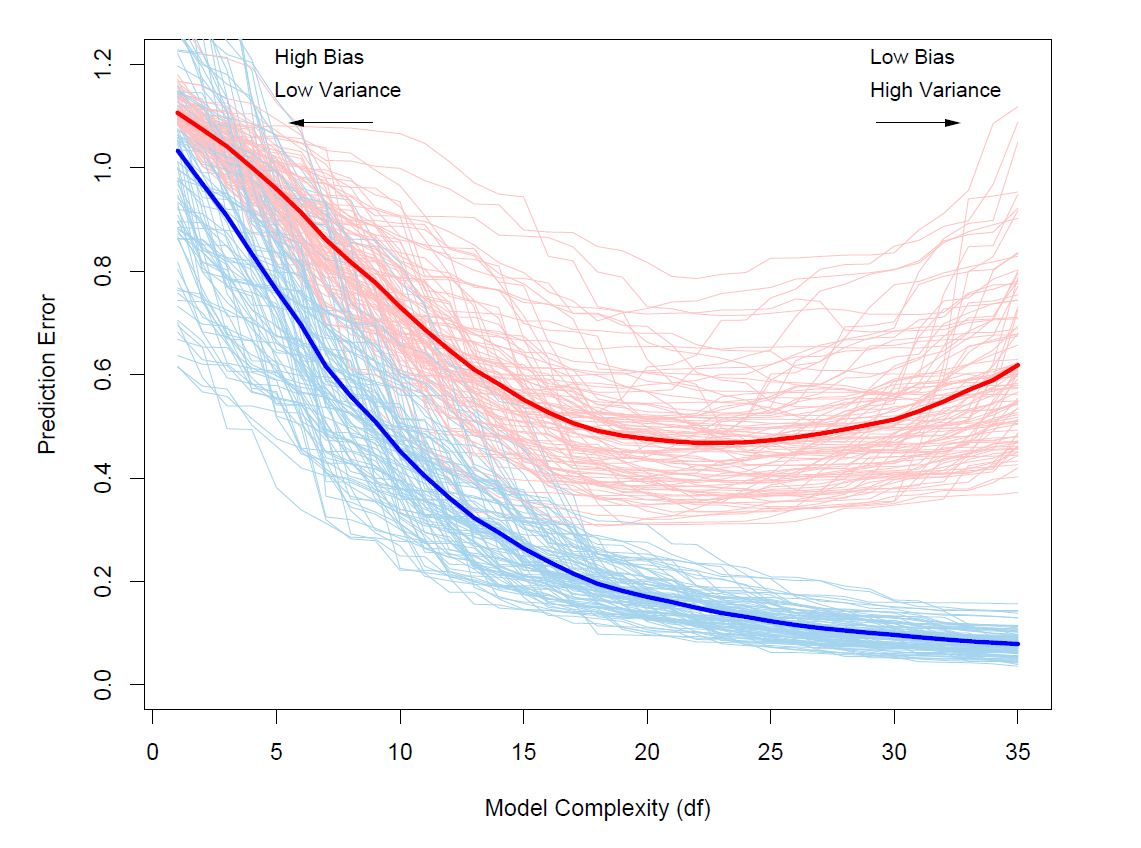

In [51]:
# Overfitting 
Image('pic/CV.jpg', width=700, height=500)

<span style='color: blue, font-size=12pt'> Learing Sample = Train Set = Обучающая выборка </span>  VS
<span style='color: red, font-size=12pt'> Validation Sample = Validation Set = Контрольная выборка </span>

<span style='color: green, font-size=12pt'> Переобучение - это явление (эффект), связанное с тем, что с ростом сложности семейства алгоритмов будет ухудшаться (с некоторого момента), точность на контрольной выборке.</span>

** Вопросы **
 Как избежать переобучения? (как его обнаружить)

** Split dataset to train\validate (hold-out CV) ** 
  * split $X=\{x_i,y_i\}^\ell_{i=1} = X^m\cup X^k$ on 2 parts ($k+m = l$)
  * train $a = \mu(X^m).$
  * calculate quality measure $Q=Q(a,X^k)$

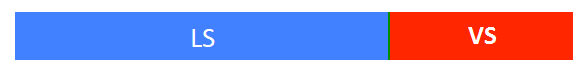

In [53]:
Image('pic/TrainValidate.png')

** Cross-validation **
   * repeat spitting for $N$ times 
   * calculate average empirical risk: 
$$CV(\mu,X^\ell)=\frac{1}{N}\sum_{n=1}^N Q(a_n,X^k_n)$$

   * types of CV
      - complete CV
      - q-fold CV
      - txq-fold CV

** Useful links **
*  <a href="https://github.com/ml-mipt/ml-mipt-part1/blob/master/2017/seminars/02-sklearn/sklearn-cross-validation.ipynb"> cross-validation in sklearn </a>

### Bias-variance trade-off

** Bias Variance Idea **
   * Given a model $a_{LS}$ built from learning sample $LS$.
    - Its generalization error (useful for model assessment):
$$ Err_{LS}=E_{X,Y}\{\mathcal L(y, a_{LS})\}$$

   * Given a learning algorithm $\mu$ trained on $LS$ of size $\ell$
     - Its error (useful to describe learning algorithm):
    $E_{LS} {Err_{LS} }=E_{LS} \left\{E_{X,Y}\{\mathcal L(y, a_{LS})\}\right\}$

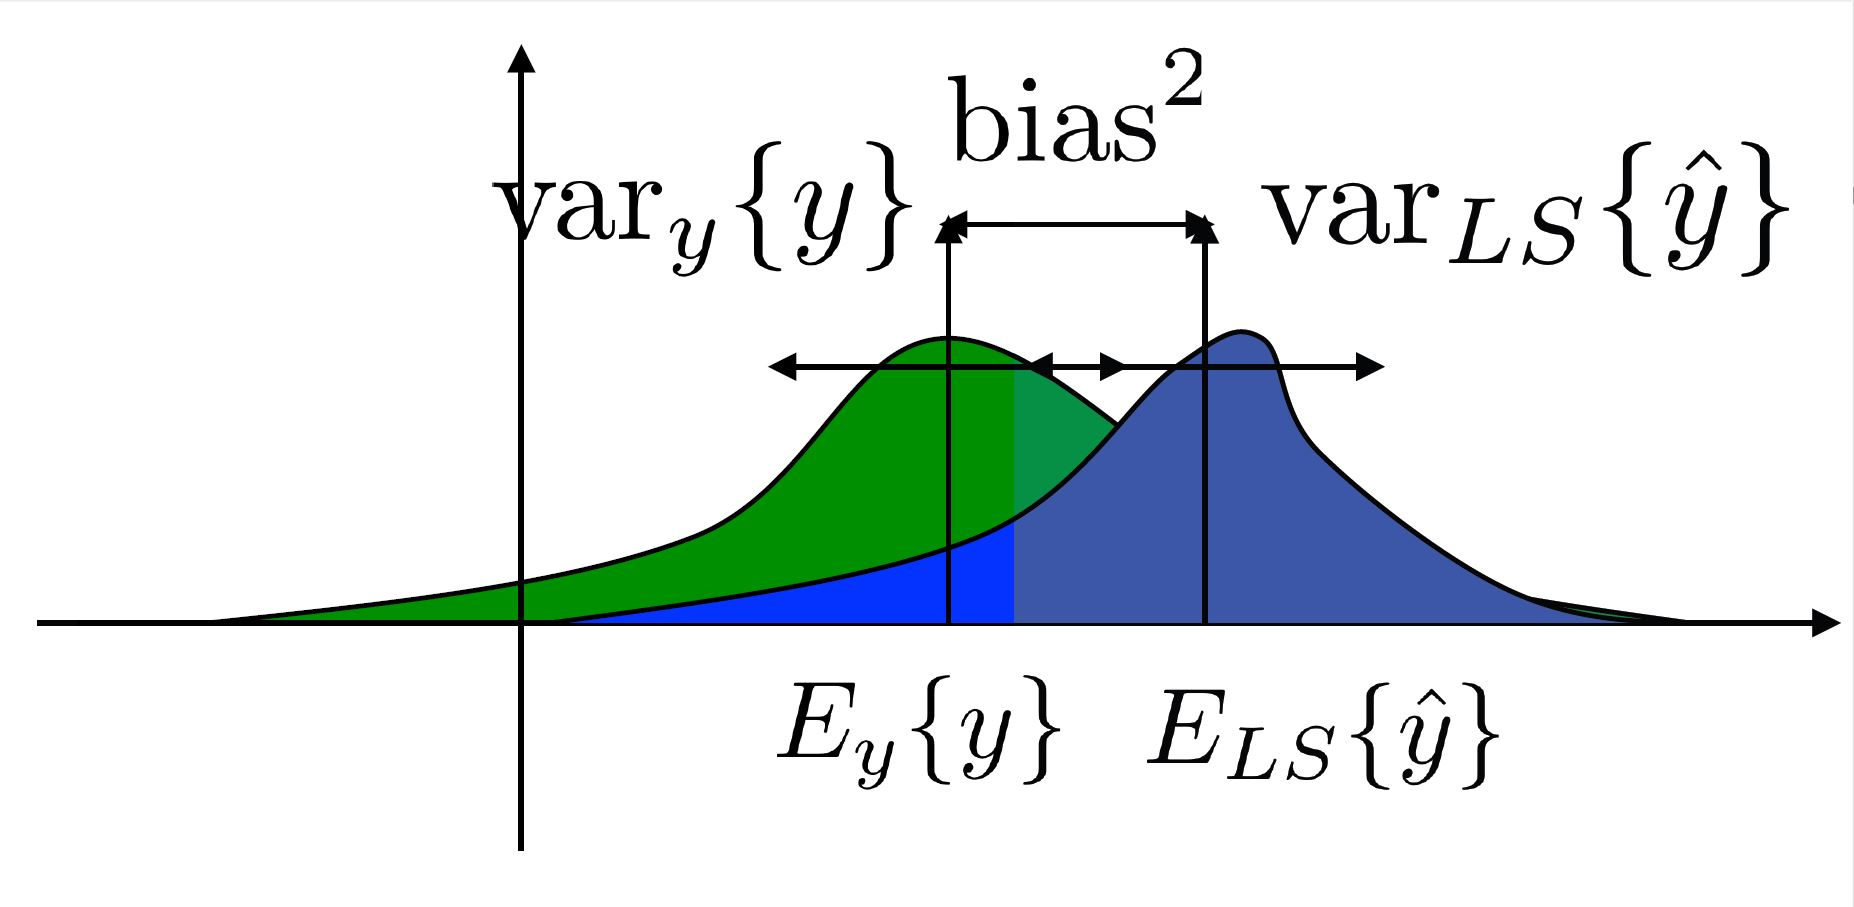

In [2]:
Image('pic/BVIdea.jpg', width=700, height=700)

** Вывод для регрессии при квадратичной функции потерь ** 
* simple regression model $Err_{LS} = E_y \left\{(y-\hat{y})^2\right\}$:
* a good algorithm should minimize an error not only on one $LS$, but in average over all $LS$ of size $\ell$:

\begin{equation}
    \begin{split}
        &  E_{LS} \left\{E_{Y}\{(y - \hat{y})^2\}\right\} = E_{LS} \left\{E_{Y}\{(y - E_Y\{y\} + E_Y\{y\} - \hat{y})^2\}\right\} = \\
          = & E_{LS} \left\{E_{Y}\{(y - E_Y\{y\})^2\}\right\} + E_{LS} \left\{E_{Y}\{(E_Y\{y\} - \hat{y})^2\}\right\}+
        2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} = \\
          = & E_{Y}\{(y - E_Y\{y\})^2\} + E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}
        + 2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} =\\
         & = \color{red}{\underbrace{E_{Y}\{(y - E_Y\{y\})^2\}}_{var_Y\{y\}}} +\color{black}{E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}}
    \end{split}
\end{equation}

\begin{equation}
    \begin{split}
        & E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\} = E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\} + E_{LS}\{\hat{y}\} - \hat{y})^2\right\} = \\
        & =E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2\right\} + E_{LS} \left\{(E_{LS}\{\hat{y}\} - \hat{y})^2\right\}
         + E_{LS} \left\{2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - \hat{y})\right\} = \\
        & =(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 + E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\} + 2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - E_{LS}\{\hat{y}\}) = \\
        & = \color{red}{\underbrace{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 }_{bias^2}}+ \color{red}{\underbrace{E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\}}_{variance}}
    \end{split}
\end{equation}

* более полная версия для регрессии и knn: https://github.com/ml-mipt/ml-mipt-part1/blob/master/2017/seminars/03-pandas/bias_variance.pdf

** Пример **:
Предсказать средний рост группы 59x , которая поступит на физтех в 2025 году, зная возраст всех 59x групп прошлых лет. 

Решение: используется 2 модели

## 1) $$\hat{y}=\frac{1}{l}\sum_{i=1}^l y_i$$
## 2) $$\hat{y}=\frac{\lambda\cdot 180+\sum_{i=1}^l y_i}{\lambda+l}$$

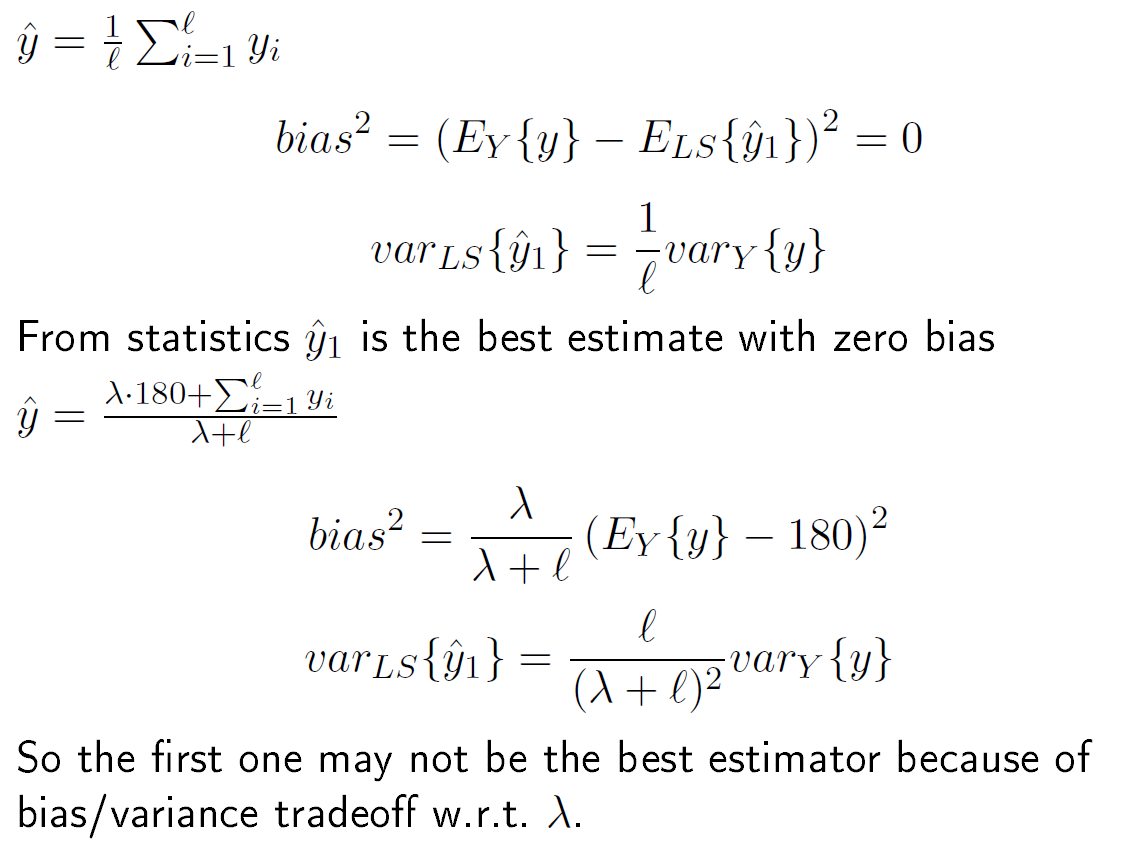

In [62]:
Image('pic/BiasVarianceExample.png', width=500, height=500)

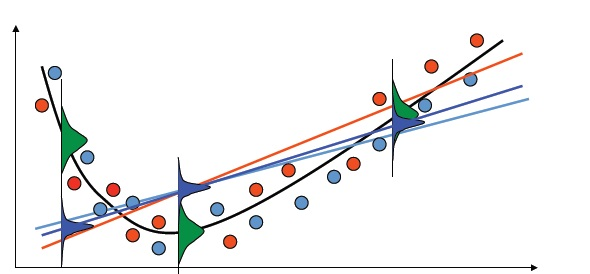

In [63]:
# Underfitting via Bias-Variance approach
Image('pic/Underfitting.jpg')

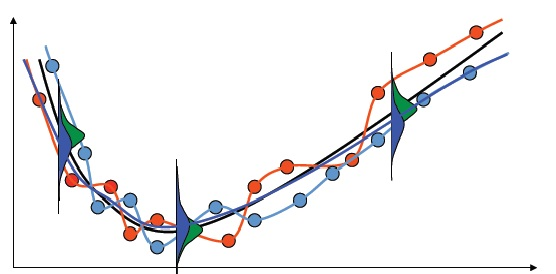

In [65]:
# Overfitting via Bias-Variance approach
Image('pic/Overfitting1.jpg')

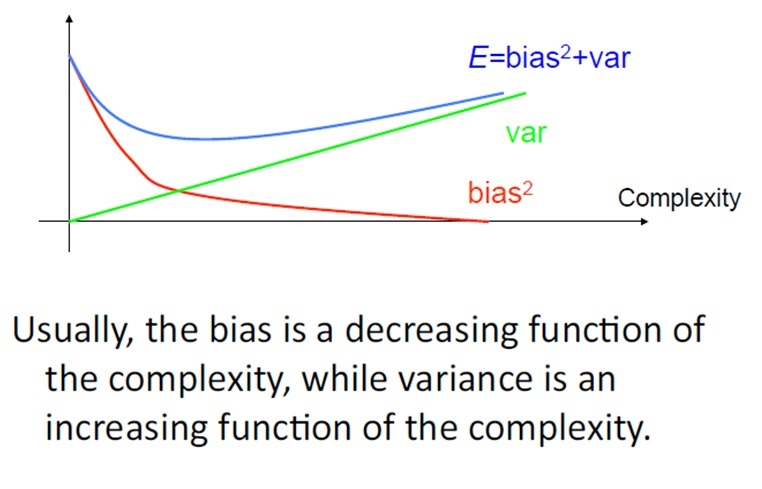

In [68]:
# Two types of error
Image('pic/BiasVariance.jpg', width=500, height=500)

## Bayes Approach. Naive Bayes

#### Функционал среднего риска
$$R(a) = \sum\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx=\int\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx $$
* paragraph 2.1 http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf

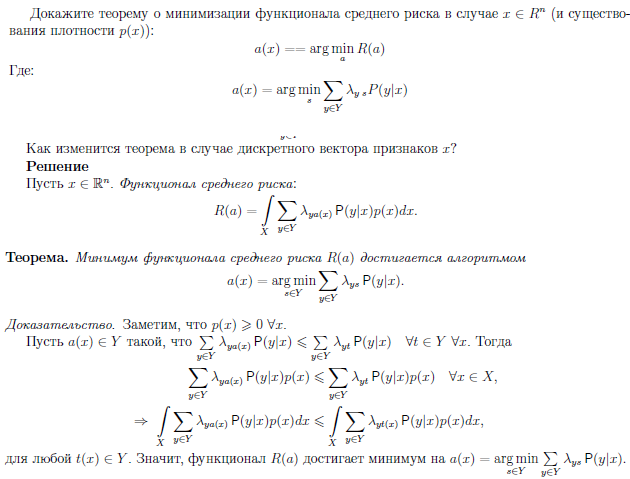

In [5]:
Image('pic/Task1.PNG')

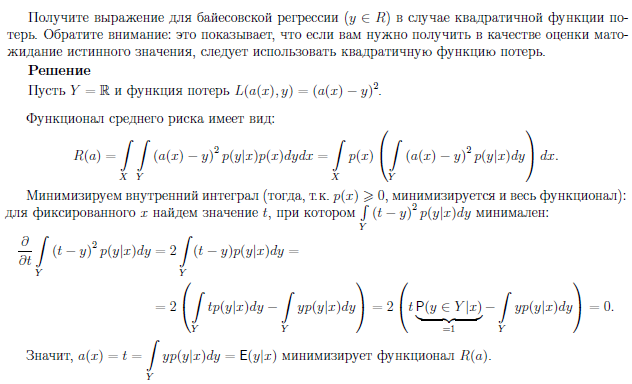

In [6]:
Image('pic/Task2.png')

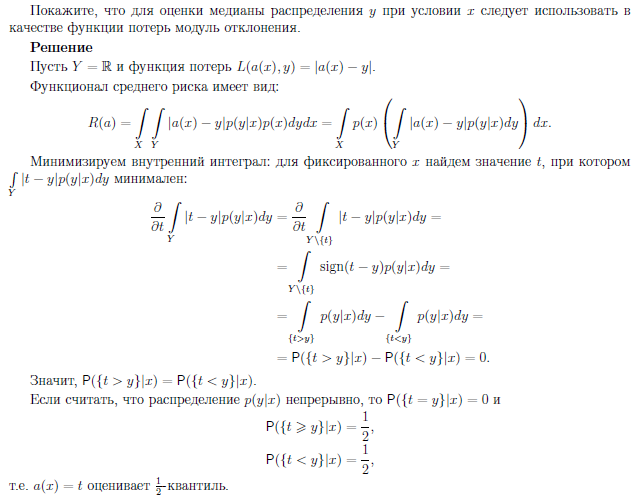

In [8]:
Image('pic/Task3.png')

# HW1:
* <a href = "https://github.com/ml-mipt/ml-mipt-part1/blob/master/2017/home_work/knn_cross_validation/task1_496.ipynb"> HW#1 <a>
     - <span style='color:blue; font-size:10pt'> Обратите внимание на правила сдачи ДЗ! </span>

  
  * оцените <a href="https://docs.google.com/forms/d/e/1FAIpQLSdmyY3f-lwrhSGeqJPaxcXrdj0SfZzZbgRIggg-nx4EQ_eQLQ/viewform?c=0&w=1"> семинар </a>
  * оставьте <a href="https://docs.google.com/forms/d/e/1FAIpQLSdefy8neFtoxDlXD3toHi3fWB3OW-23APTRj-GuTX8wtAJahQ/viewform?c=0&w=1"> отзыв </a> о лекции 

# Summary

* Отбор признаков позволяет существенно повысить качество и/или упростить решение
* Разные метрики проводят к существенно разным ответам
* Для наиболее 
* Bias-variance tradeoff - один из возможных взглядов на проблему переобучения
    - помогает понять, как работают алгоритмы ML
* Naive Bayes - very simple and profitable ML algorithm